In [1]:
from cil.optimisation.functions.L2NormSquared import L2NormSquared
from cil.utilities import dataexample
from cvxpy import *
from regularisers import tv
from cil.optimisation.functions import TotalVariation
import numpy as np
import matplotlib.pyplot as plt
from cil.utilities.display import show2D

# Load data and resize

In [2]:
data = dataexample.CAMERA.get(size=(32, 32))

# Setup and run tv denoising with cvxpy

In [3]:
# solution
u_cvx = Variable(data.shape)

# regularisation parameter
alpha = 0.1

# fidelity term
fidelity = 0.5 * sum_squares(u_cvx - data.array)   
regulariser = alpha * tv(u_cvx)

# objective
obj =  Minimize( regulariser +  fidelity)
prob = Problem(obj, constraints = [])

# Choose solver ( SCS, MOSEK(license needed) )
tv_cvxpy = prob.solve(verbose = True, solver = SCS)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Dec 06 07:30:26 PM: Your problem has 1024 variables, 0 constraints, and 0 parameters.
(CVXPY) Dec 06 07:30:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 06 07:30:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 06 07:30:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 06 07:30:26 PM: Compiling problem (target solver=SCS).
(CVXPY) Dec 06 07:30:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

# Use TotalVariation function from CIL

In [4]:
# use TotalVariation from CIL (with Fast Gradient Projection algorithm)
TV = alpha * TotalVariation(max_iteration=100)
u_cil = TV.proximal(data, tau=1.0)

Initialised GradientOperator with C backend running with  20  threads


# Compare solutions

CVX objective = 7.893654988695406
CIL objective = 7.895644903182983


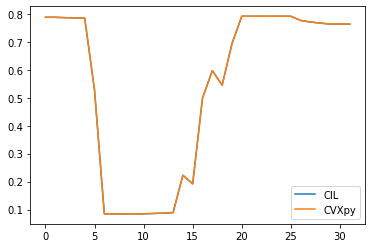

In [ ]:
# compare solution
np.testing.assert_almost_equal(u_cil.array, u_cvx.value, decimal=3)

# print objectives
print("CVX objective = {}".format(obj.value))

f = 0.5*L2NormSquared(b=data)
cil_objective = TV(u_cil) + f(u_cil)
print("CIL objective = {}".format(cil_objective))

# show middle line profiles
N, M = data.shape
plt.figure()
plt.plot(u_cil.array[int(N/2)], label="CIL")
plt.plot(u_cvx.value[int(N/2)], label="CVXpy")
plt.legend()
plt.show()

show2D([u_cil.array, u_cvx.value, np.abs(u_cil.array - u_cvx.value)], num_cols = 3, origin="upper")